<a href="https://colab.research.google.com/github/defneuras/Cloud-detection-in-the-Arctic/blob/main/CNN_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import requests
from datetime import datetime, timedelta
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Load patches and labels from previous notebook
X = np.load('/content/drive/MyDrive/Sentinel2_PondInlet_Exports/X_patches_L2A.npy')
y = np.load('/content/drive/MyDrive/Sentinel2_PondInlet_Exports/y_labels_L2A.npy')


print("Patches shape:", X.shape)
print("Labels shape:", y.shape)



Mounted at /content/drive
Patches shape: (14980, 64, 64, 6)
Labels shape: (14980,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize reflectance
X = X / 10000.0 # Sentinel-2 reflectance normalization

# Encode labels to integers → one-hot
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int)

print("Unique classes:", le.classes_)

Unique classes: [ 8  9 10 11]


In [ ]:
from sklearn.utils import class_weight

# Compute class weights from integer labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_int),
    y=y_int
)
class_weights_dict = dict(enumerate(class_weights))


# Convert to dictionary format Keras expects
print("Class weights:", class_weights_dict)

Training samples: 11984
Validation samples: 2996


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 6)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax') # num classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,532 (6.20 MB)

 Trainable params: 1,626,532 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 95s 247ms/step - accuracy: 0.8786 - loss: 0.4305 - val_accuracy: 0.8925 - val_loss: 0.3816
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 137s 235ms/step - accuracy: 0.9030 - loss: 0.3341 - val_accuracy: 0.9045 - val_loss: 0.3265
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 144s 241ms/step - accuracy: 0.9075 - loss: 0.3060 - val_accuracy: 0.9002 - val_loss: 0.3516
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 138s 232ms/step - accuracy: 0.9133 - loss: 0.2933 - val_accuracy: 0.9206 - val_loss: 0.2391
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 229ms/step - accuracy: 0.9135 - loss: 0.2617 - val_accuracy: 0.9035 - val_loss: 0.2797
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 231ms/step - accuracy: 0.9204 - loss: 0.2521 - val_accuracy: 0.9222 - val_loss: 0.2088
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 90s 241ms/step - accuracy: 0.9230 - loss: 0.2250 - val_accuracy: 0.9216 - val_loss: 0.2500
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 144s 247ms/step - accuracy: 0.9293 - lo

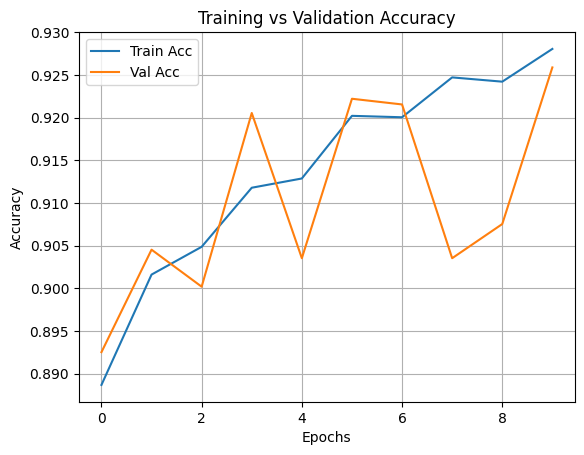

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Sentinel2_PondInlet_Exports/cnn_scl_model.h5')

In [ ]:
preds = model.predict(X_val[:5])
pred_classes = le.inverse_transform(np.argmax(preds, axis=1))
true_classes = le.inverse_transform(np.argmax(y_val[:5], axis=1))

print("True:", true_classes)
print("Predicted:", pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
True: [11 11 11 11  8]
Predicted: [11 11 11 11  8]


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step
              precision    recall  f1-score   support

           8       0.59      0.51      0.54       216
           9       0.75      1.00      0.86        24
          10       0.54      0.48      0.51       125
          11       0.97      0.98      0.97      2631

    accuracy                           0.93      2996
   macro avg       0.71      0.74      0.72      2996
weighted avg       0.92      0.93      0.92      2996



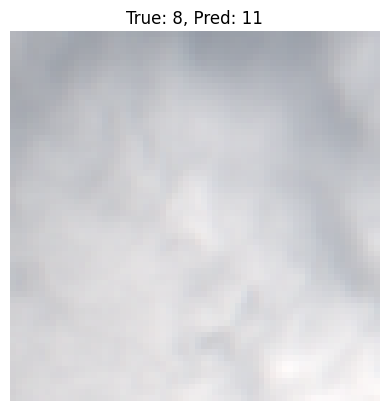

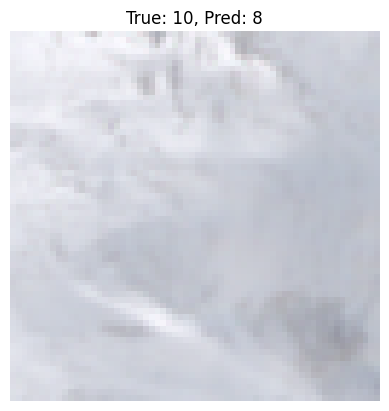

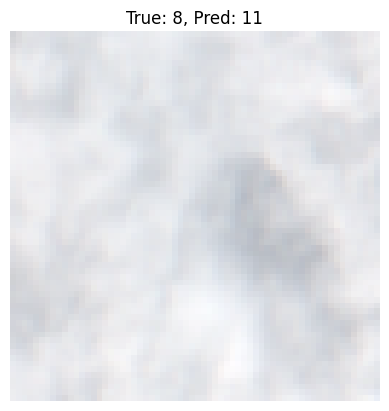

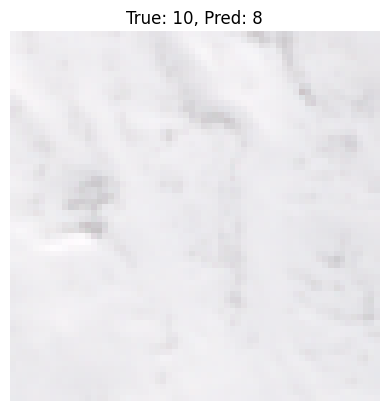

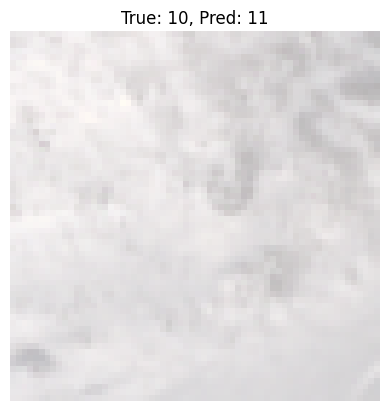

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Text report
# Explicitly provide the labels parameter to match target_names
# The labels should be the integer representations of the classes,
# which correspond to the indices in le.classes_.
labels_for_report = np.arange(len(le.classes_))

print(classification_report(y_true, y_pred, labels=labels_for_report, target_names=le.classes_.astype(str)))

# Show example misclassified patches
misclassified = np.where(y_pred != y_true)[0]
for idx in misclassified[:5]:
    patch_rgb = X_val[idx][:,:, [2,1,0]]
    patch_rgb /= np.max(patch_rgb) # Ensure proper scaling for visualization

    plt.imshow(patch_rgb)
    # Use le.inverse_transform on single-element arrays or lists
    plt.title(f"True: {le.inverse_transform([y_true[idx]])[0]}, Pred: {le.inverse_transform([y_pred[idx]])[0]}")
    plt.axis('off')
    plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


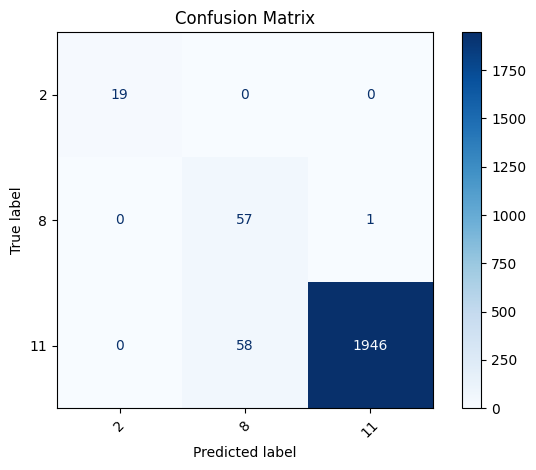

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Convert from one-hot to integer class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Get class names from label encoder
# class_names = le.classes_.astype(str) # Original line

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the unique class labels present in the true validation data (y_true)
# And map them back to their original string names using the label encoder
unique_true_classes_int = np.unique(y_true)
# Filter the original class names to only include those present in the validation set
class_names_for_display = le.inverse_transform(unique_true_classes_int).astype(str)


# Plot with labels
# Use the filtered class names for display_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_for_display)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

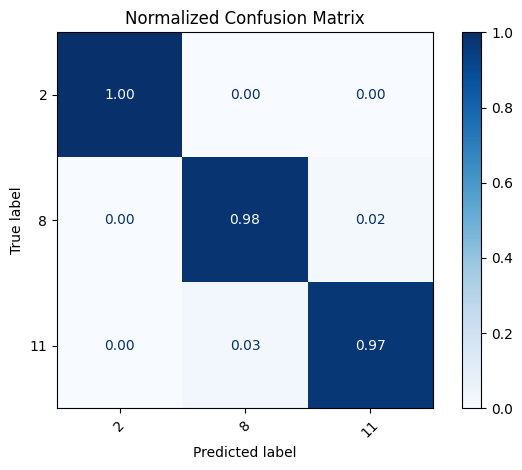

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=1, keepdims=True),
                              # Use the correctly filtered class names from the previous cell
                              display_labels=class_names_for_display)
disp.plot(cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()